In [18]:
# 基本ライブラリ
import os, re, csv, math, statistics
from datetime import datetime, timedelta
from decimal import Decimal

# 数値計算とデータ処理
import numpy as np
import pandas as pd
import bottleneck as bn

# 機械学習ライブラリ
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ディープラーニングライブラリ
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Conv1D, MaxPooling1D, Flatten

# プロットと可視化
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib

# その他のライブラリ
from scipy import signal, stats
from tslearn.metrics import dtw_path

In [19]:
#Apple Watchからのモーションデータを読み込む関数
def process_apple_watch_csv(file_path):
    # CSVファイルの読み込み
    motion_data = pd.read_csv(file_path, header=0, names=['UnixTime', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'GyroX', 'GyroY', 'GyroZ'])
    # Unixタイムスタンプを日本時間に変換し、タイムゾーン情報を削除して表示する
    motion_data['Timestamp'] = pd.to_datetime(motion_data['UnixTime'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Tokyo').dt.tz_localize(None)
    # 加速度のユークリッドノルムを計算してデータフレームに追加
    motion_data['EuclideanNorm'] = np.sqrt(motion_data['AccelerationX']**2 + motion_data['AccelerationY']**2 + motion_data['AccelerationZ']**2)
    # FFTのサンプル数を取得
    N = len(motion_data)
    # サンプリングレートを定義 (50Hzとする)
    Fs = 50
    # FFT解析を行い、3軸加速度のパワースペクトルを計算してデータフレームに追加
    for axis in ['AccelerationX', 'AccelerationY', 'AccelerationZ', 'EuclideanNorm']:
        accel_fft = np.fft.fft(motion_data[axis])
        power_spectrum = np.abs(accel_fft)**2
        motion_data[f'PowerSpectrum_{axis}'] = power_spectrum

    return motion_data

In [20]:
def all_process_apple_watch_csv(directory_path, gesture):
    # ディレクトリ内のすべてのCSVファイルを検索
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.csv')]
    # 全ファイルのデータを格納するリスト
    all_data = []
    # 各ファイルを処理
    for file_path in files:
        # ファイルを読み込み、初期処理を行う
        data = process_apple_watch_csv(file_path)
        #data = data.loc[:, ['AccelerationX', 'AccelerationY', 'AccelerationZ']]
        data = data.loc[:, ['AccelerationX', 'AccelerationY', 'AccelerationZ', 'GyroX', 'GyroY', 'GyroZ']]

        # 150行にデータを整形する
        for start in range(0, len(data), 150):
            segment = data.iloc[start:start + 150]

            if len(segment) < 150:
                # パディングが必要な場合
                padding_length = 150 - len(segment)
                padding = pd.DataFrame(np.zeros((padding_length, len(data.columns))), columns=data.columns)
                segment = pd.concat([segment, padding], ignore_index=True)
            elif len(segment) > 150:
                # 150行を超えている場合は最初の150行のみを使用
                segment = segment.iloc[:150]

            # データを配列に追加
            all_data.append(segment)

    labels = np.full((len(all_data)), gesture)
    # リストをNumPyの3次元配列に変換
    return np.array(all_data), labels


In [21]:
#Tobii Pro Glasses 2からのアイトラッキングデータを読み込む関数
def process_tobii_csv(file_path):
    # CSVファイルの読み込み
    eye_data = pd.read_csv(file_path, header=0)
    #タイムスタンプをYYYY-MM-DD HH:MM:SS.fff形式に変換
    eye_data['Recording start time'] = pd.to_datetime(eye_data['Recording start time'], format='%H:%M:%S.%f')
    eye_data['Recording date'] = pd.to_datetime(eye_data['Recording date'], format='%m/%d/%Y')
    eye_data['Recording timestamp'] = pd.to_datetime(eye_data['Recording timestamp'], unit='us')
    eye_data['Timestamp'] = eye_data['Recording date'] + pd.to_timedelta(eye_data['Recording start time'].dt.strftime('%H:%M:%S.%f')) + pd.to_timedelta(eye_data['Recording timestamp'].dt.strftime('%H:%M:%S.%f'))

    return eye_data[(eye_data['Sensor'] == 'Eye Tracker')].drop(columns=['Recording timestamp', 'Computer timestamp', 'Recording start time UTC', 'Recording duration', 'Recording Fixation filter name', 'Project name', 'Export date', 'Recording name','Recording date', 'Recording date UTC', 'Recording start time', 'Recording media name', 'Recording media width', 'Recording media height', 'Gyro X', 'Gyro Y', 'Gyro Z', 'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z'])

In [22]:
def process_watch_and_tobii_data(motion_data, eye_data):
    # データをマージ
    merged_data = pd.merge(eye_data, motion_data, on="Timestamp", how='outer')
    # eye_dataとmotion_dataのタイムスタンプ範囲を取得
    start_time = max(eye_data['Timestamp'].min(), motion_data['Timestamp'].min())
    end_time = min(eye_data['Timestamp'].max(), motion_data['Timestamp'].max())

    # マージ後のデータフレームを調整
    filtered_data = merged_data[(merged_data['Timestamp'] >= start_time) & (merged_data['Timestamp'] <= end_time)]

    return filtered_data

In [37]:
def dist(x, y):
    return (x - y)**2

def get_min(m0, m1, m2, i, j):
    if m0 < m1:
        if m0 < m2:
            return i - 1, j, m0
        else:
            return i - 1, j - 1, m2
    else:
        if m1 < m2:
            return i, j - 1, m1
        else:
            return i - 1, j - 1, m2

In [38]:
def spring(x, y, epsilon):
    Tx = len(x)
    Ty = len(y)

    C = np.zeros((Tx, Ty))
    B = np.zeros((Tx, Ty, 2), int)
    S = np.zeros((Tx, Ty), int)

    C[0, 0] = dist(x[0], y[0])

    for j in range(1, Ty):
        C[0, j] = C[0, j - 1] + dist(x[0], y[j])
        B[0, j] = [0, j - 1]
        S[0, j] = S[0, j - 1]

    for i in range(1, Tx):
        C[i, 0] = dist(x[i], y[0])
        B[i, 0] = [0, 0]
        S[i, 0] = i

        for j in range(1, Ty):
            pi, pj, m = get_min(C[i - 1, j],
                                C[i, j - 1],
                                C[i - 1, j - 1],
                                i, j)
            C[i, j] = dist(x[i], y[j]) + m
            B[i, j] = [pi, pj]
            S[i, j] = S[pi, pj]

        imin = np.argmin(C[:(i+1), -1])
        dmin = C[imin, -1]

        if dmin > epsilon:
            continue

        for j in range(1, Ty):
            if (C[i,j] < dmin) and (S[i, j] < imin):
                break
        else:
            path = [[imin, Ty - 1]]
            temp_i = imin
            temp_j = Ty - 1

            while (B[temp_i, temp_j][0] != 0 or B[temp_i, temp_j][1] != 0):
                path.append(B[temp_i, temp_j])
                temp_i, temp_j = B[temp_i, temp_j].astype(int)

            C[S <= imin] = 100000000
            yield np.array(path), dmin

In [29]:
def plot_spring(data_x, data_y, timestamps, epsilon=0.06):
    pathes = []
    times = []

    for path, cost in spring(data_x, data_y, epsilon):
        plt.figure(figsize=(36, 6))  # グラフを横長にする

        # マッチングパスをプロット
        for line in path:
            plt.plot([timestamps[line[0]], timestamps[line[1]]], [data_x[line[0]], data_y[line[1]]], linewidth=0.8, c="gray")

        # 長いストリームデータと短いパターンデータをプロット
        plt.plot(timestamps, data_x, label='long data')
        plt.plot(timestamps[:len(data_y)], data_y, label='gesture data')

        # マッチングパスの部分をプロット
        plt.plot(timestamps[path[:,0]], data_x[path[:,0]], c="C2", label='similar')

        plt.grid(True)  # グリッド表示
        plt.legend()  # 凡例表示
        plt.xticks(rotation=45)  # x軸のラベルを45度回転

        plt.show()

        times.append(timestamps[path[:,0]])
        pathes.append(path)

    return pathes, times

In [44]:
def plot_spring_3axis(data_x, data_y, timestamps, epsilon=0.07):
    results = {}

    for axis in ['AccelerationX', 'AccelerationY', 'AccelerationZ']:
        print(f'Processing axis: {axis}')
        pathes, times = plot_spring(data_x[axis], data_y[axis], timestamps, epsilon)
        results[axis] = {'pathes': pathes, 'times': times}

    return results

In [40]:
kawano_check, labels1 = all_process_apple_watch_csv("datasets/kawano/train_gesture/kawano_check", "check")
kawano_circle, labels2 = all_process_apple_watch_csv("datasets/kawano/train_gesture/kawano_circle", "circle")
kawano_cross, labels3 = all_process_apple_watch_csv("datasets/kawano/train_gesture/kawano_cross", "cross")
kawano_tri, labels4 = all_process_apple_watch_csv("datasets/kawano/train_gesture/kawano_tri", "tri")

In [43]:
kawano = np.concatenate([kawano_check, kawano_circle, kawano_cross, kawano_tri])
label =  np.concatenate([labels1, labels2, labels3, labels4])

In [ ]:
encoder = LabelEncoder()
# データをフィットして変換
label = encoder.fit_transform(label)

In [ ]:
label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(kawano, label, test_size=0.2) #random_state=42

In [40]:
motion_data20240510 = process_apple_watch_csv("datasets/kawano/20240510/MotionData_20240510_151453.csv")

In [31]:
circle = process_apple_watch_csv("datasets/kawano/train_gesture/kawano_circle/acceleration_rotationrate_0.02s_20240510173949.csv")

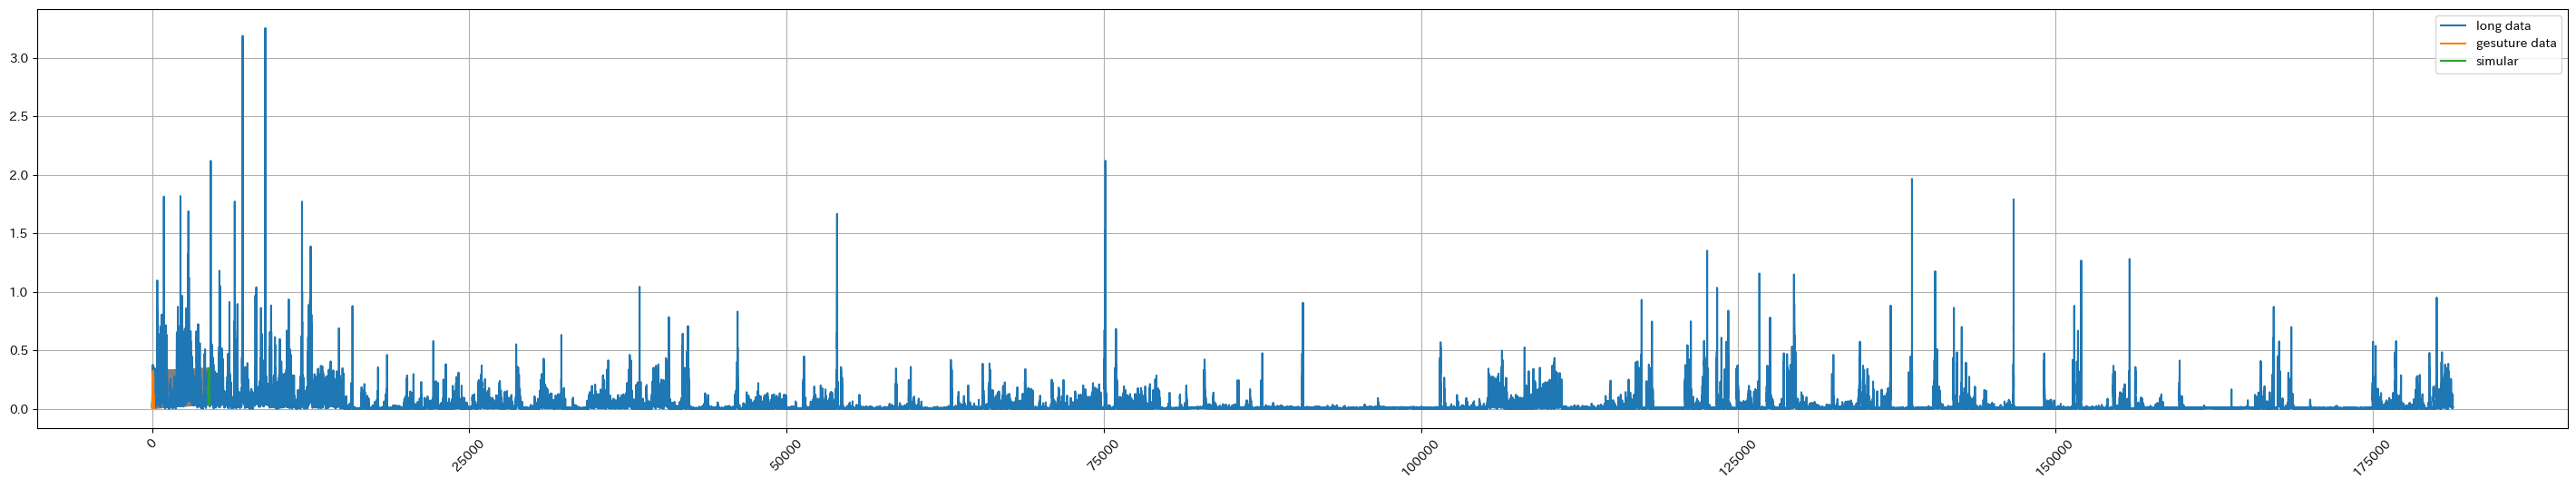

KeyboardInterrupt: 

In [46]:
pathes, times = plot_spring(motion_data20240510['EuclideanNorm'], circle['EuclideanNorm'], motion_data20240510['Timestamp'])

In [15]:
times

[4519   2024-05-10 15:16:24.355884032
 4519   2024-05-10 15:16:24.355884032
 4519   2024-05-10 15:16:24.355884032
 4518   2024-05-10 15:16:24.336016128
 4517   2024-05-10 15:16:24.316177920
                     ...             
 4399   2024-05-10 15:16:21.957144064
 4399   2024-05-10 15:16:21.957144064
 4399   2024-05-10 15:16:21.957144064
 4399   2024-05-10 15:16:21.957144064
 4399   2024-05-10 15:16:21.957144064
 Name: Timestamp, Length: 203, dtype: datetime64[ns],
 106065   2024-05-10 15:50:14.170479104
 106065   2024-05-10 15:50:14.170479104
 106065   2024-05-10 15:50:14.170479104
 106065   2024-05-10 15:50:14.170479104
 106064   2024-05-10 15:50:14.150525184
                       ...             
 106031   2024-05-10 15:50:13.490953984
 106031   2024-05-10 15:50:13.490953984
 106031   2024-05-10 15:50:13.490953984
 106031   2024-05-10 15:50:13.490953984
 106031   2024-05-10 15:50:13.490953984
 Name: Timestamp, Length: 155, dtype: datetime64[ns],
 110634   2024-05-10 15:51:45.5005

In [50]:
motion_data20240510['EuclideanNorm'].max()

3.25237124720773

In [ ]:
# モデルの定義
model = Sequential([
    LSTM(32, input_shape=(150, 6)),  # 64ユニットのLSTM層
    Dense(4, activation='softmax')  # 出力層（4つのジェスチャクラス）
])


# モデルのコンパイル
model.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)


In [ ]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(150, 6)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# モデルの訓練
#model.fit(X_train, y_train, epochs=10, batch_size=32)
model.fit(X_train, y_train, epochs=10, shuffle=True, batch_size=32, validation_split=0.2)
#model.fit(kawano, label, epochs=10, shuffle=True, batch_size=32, validation_split=0.2)

#y_pred = model.predict(X_test)


In [ ]:
# 最も確率の高いクラスのインデックスを取得
predicted_classes = np.argmax(y_pred, axis=1)
accuracy_score(y_test, predicted_classes)

In [ ]:
motion_data20240510 = process_apple_watch_csv("datasets/kawano/20240510/MotionData_20240510_151453.csv")
eye_data20240510 = process_tobii_csv('datasets/kawano/20240510/kawano Data Export.csv')
data20240510 = process_watch_and_tobii_data(motion_data20240510, eye_data20240510)

In [ ]:
eye = process_tobii_csv("datasets/kawano/20240510/kawano_one_hour.csv")

In [ ]:
data20240504

In [ ]:
motion_data = process_apple_watch_csv("datasets/kawano/20240510/MotionData_20240510_151453.csv")

In [ ]:
window_size = 150
step_size = 50

In [ ]:
# スライディングウィンドウの適用
num_windows = (len(motion_data) - window_size) // step_size + 1
windows = [motion_data.iloc[i:i+window_size] for i in range(0, len(motion_data) - window_size + 1, step_size)]


In [ ]:
# モデルの予測とタイムスタンプの抽出
gesture_intervals = []
for window in windows:
    # 加速度データの抽出
    window_data = window[['AccelerationX',  'AccelerationY', 'AccelerationZ', 'GyroX', 'GyroY', 'GyroZ']].values[None, :, :]
    # モデルの予測
    prediction = model.predict(window_data)
    max_prediction = np.max(prediction)
    predicted_class = np.argmax(prediction)

    if max_prediction > 0.7:
        # タイムスタンプの取得
        start_time = window.iloc[0]['Timestamp']
        end_time = window.iloc[-1]['Timestamp']
        gesture_intervals.append((start_time, end_time, predicted_class, max_prediction))

# 結果の表示
print("Detected gesture intervals with timestamps and confidence:")
for start, end, cls, conf in gesture_intervals:
    print(f"Start: {start}, End: {end}, Class: {cls}, Confidence: {conf:.2f}")

In [ ]:
num_windows

In [ ]:
motion_data['Timestamp'].diff().sort_values(ascending=0)

In [ ]:
motion_data['Timestamp'].diff().mean()

In [ ]:
base_timestamps = [
    [pd.to_datetime('2024-05-04 18:30:00'), '0'],
    [pd.to_datetime('2024-05-04 18:31:00'), '1'],
    [pd.to_datetime('2024-05-04 18:32:00'), '2'],
    [pd.to_datetime('2024-05-04 18:33:00'), '3'],
    [pd.to_datetime('2024-05-04 18:34:00'), '5'],
    [pd.to_datetime('2024-05-04 18:35:00'), '4'],
    [pd.to_datetime('2024-05-04 18:36:00'), '6'],
    [pd.to_datetime('2024-05-04 18:37:00'), '7'],
    [pd.to_datetime('2024-05-04 18:38:00'), '8'],
    [pd.to_datetime('2024-05-04 18:39:00'), '9'],
    [pd.to_datetime('2024-05-04 18:44:00'), '0'],
    [pd.to_datetime('2024-05-04 18:44:30'), '1'],
    [pd.to_datetime('2024-05-04 18:45:00'), '2'],
    [pd.to_datetime('2024-05-04 18:45:30'), '3'],
    [pd.to_datetime('2024-05-04 18:46:00'), '4'],
    [pd.to_datetime('2024-05-04 18:46:35'), '4'],
    [pd.to_datetime('2024-05-04 18:47:00'), '5'],
    [pd.to_datetime('2024-05-04 18:47:30'), '6'],
    [pd.to_datetime('2024-05-04 18:48:00'), '7'],
    [pd.to_datetime('2024-05-04 18:48:30'), '8'],
    [pd.to_datetime('2024-05-04 18:49:00'), '9'],
]

In [ ]:
# intervals リストを計算
intervals = [(timestamp + pd.Timedelta(seconds=-2), timestamp + pd.Timedelta(seconds=3), label) for timestamp, label in base_timestamps]

# 結果の表示
for start, end, label in intervals:
    print(f"Start: {start}, End: {end}, Label: {label}")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# プロットの初期設定
plt.figure(figsize=(60, 10))

# グレーで全データをプロット
plt.plot(data20240504['Timestamp'], data20240504['Pupil diameter filtered'], color='gray', label='Pupil Diameter Filtered') #瞳孔径
plt.plot(data20240504['Timestamp'], data20240504['EuclideanNorm'], color='gray', label='Euclidean Norm')    #3軸合成加速度

# intervals リストを使用して特定の区間を色付きでハイライト
colors = ['red', 'blue', 'green', 'orange', 'purple']  # カラーリスト
for i, (start, end, label) in enumerate(intervals):
    # 指定区間のデータを抽出
    highlight_data = data20240504[(data20240504['Timestamp'] >= start) & (data20240504['Timestamp'] <= end)]

    # 特定区間をプロット
    plt.plot(highlight_data['Timestamp'], highlight_data['Pupil diameter filtered'], color=colors[i % len(colors)], label=f'Pupil Dia: {label}')
    plt.plot(highlight_data['Timestamp'], highlight_data['EuclideanNorm'], color=colors[i % len(colors)], label=f'Euclidean Norm: {label}')

# グラフの装飾
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Highlighted Intervals in Pupil Diameter and Motion Data')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S:%f'))  # Timestampフォーマット設定
plt.tight_layout()

# プロットを表示
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# プロットの初期設定
plt.figure(figsize=(60, 10))

# Pupil diameter filtered の差分の二乗を計算
diff_squared = data20240504['Pupil diameter filtered'].diff()**2

# グレーで全データをプロット
plt.plot(data20240504['Timestamp'], diff_squared * -1, color='gray', label='Squared Diff of Pupil Diameter (Inverted)')  # 瞳孔径の差分の二乗（逆転表示）
plt.plot(data20240504['Timestamp'], data20240504['EuclideanNorm'], color='gray', label='Euclidean Norm')  # 3軸合成加速度

# intervals リストを使用して特定の区間を色付きでハイライト
colors = ['red', 'blue', 'green', 'orange', 'purple']  # カラーリスト
for i, (start, end, label) in enumerate(intervals):
    # 指定区間のデータを抽出
    highlight_data = data20240504[(data20240504['Timestamp'] >= start) & (data20240504['Timestamp'] <= end)]

    # 特定区間をプロット
    plt.plot(highlight_data['Timestamp'], highlight_data['Pupil diameter filtered'].diff()**2 * -1, color=colors[i % len(colors)], label=f'Sq Diff Pupil Dia (Inverted): {label}')
    plt.plot(highlight_data['Timestamp'], highlight_data['EuclideanNorm'], color=colors[i % len(colors)], label=f'Euclidean Norm: {label}')

# グラフの装飾
plt.xlabel('Timestamp')
plt.ylabel('Values (Inverted for Pupil Diameter Diff Squared)')
plt.title('Highlighted Intervals in Pupil Diameter and Motion Data')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S:%f'))  # Timestampフォーマット設定
plt.tight_layout()

# プロットを表示
plt.show()


In [ ]:
# プロットの初期設定
plt.figure(figsize=(160, 10))

# 注視点の移動距離を計算
data20240504['idouryou'] = np.sqrt(data20240504['Gaze point X'].diff()**2 + data20240504['Gaze point Y'].diff()**2)

# グレーで全データをプロット
plt.plot(data20240504['Timestamp'], data20240504['idouryou'], color='gray', label='Inverted - Gaze Movement Distance')  # 注視点の移動距離（逆転表示）
#plt.plot(data20240504['Timestamp'], data20240504['EuclideanNorm'], color='gray', label='Euclidean Norm')  # 3軸合成加速度

# intervals リストを使用して特定の区間を色付きでハイライト
colors = ['red', 'blue', 'green', 'orange', 'purple']  # カラーリスト
for i, (start, end, label) in enumerate(intervals):
    # 指定区間のデータを抽出
    highlight_data = data20240504[(data20240504['Timestamp'] >= start) & (data20240504['Timestamp'] <= end)]

    # 特定区間をプロット
    plt.plot(highlight_data['Timestamp'], highlight_data['idouryou'], color=colors[i % len(colors)], label=f'Inverted Gaze Move: {label}')
    #plt.plot(highlight_data['Timestamp'], highlight_data['EuclideanNorm'], color=colors[i % len(colors)], label=f'Euclidean Norm: {label}')

# グラフの装飾
plt.xlabel('Timestamp')
plt.ylabel('Gaze Movement Distance (downward)')
plt.title('Highlighted Intervals in Gaze Movement')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S:%f'))  # Timestampフォーマット設定
plt.tight_layout()

# プロットを表示
plt.show()
